In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

In [2]:
!kaggle datasets download -d trolukovich/food11-image-dataset

Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0
100% 1.08G/1.08G [00:48<00:00, 24.7MB/s]
100% 1.08G/1.08G [00:48<00:00, 24.1MB/s]


In [3]:
!unzip food11-image-dataset.zip -d /content/food11

Показано результат, скорочений до останніх рядків (5000).
  inflating: /content/food11/training/Soup/223.jpg  
  inflating: /content/food11/training/Soup/224.jpg  
  inflating: /content/food11/training/Soup/225.jpg  
  inflating: /content/food11/training/Soup/226.jpg  
  inflating: /content/food11/training/Soup/227.jpg  
  inflating: /content/food11/training/Soup/228.jpg  
  inflating: /content/food11/training/Soup/229.jpg  
  inflating: /content/food11/training/Soup/23.jpg  
  inflating: /content/food11/training/Soup/230.jpg  
  inflating: /content/food11/training/Soup/231.jpg  
  inflating: /content/food11/training/Soup/232.jpg  
  inflating: /content/food11/training/Soup/233.jpg  
  inflating: /content/food11/training/Soup/234.jpg  
  inflating: /content/food11/training/Soup/235.jpg  
  inflating: /content/food11/training/Soup/236.jpg  
  inflating: /content/food11/training/Soup/237.jpg  
  inflating: /content/food11/training/Soup/238.jpg  
  inflating: /content/food11/training/Soup

In [4]:
batch_size=256
image_size=(100, 100)

In [5]:
train_dataset = image_dataset_from_directory('food11/training',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 9866 files belonging to 11 classes.
Using 8880 files for training.


In [6]:
validation_dataset = image_dataset_from_directory('food11/validation',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 3430 files belonging to 11 classes.
Using 343 files for validation.


In [7]:
class_names = train_dataset.class_names
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

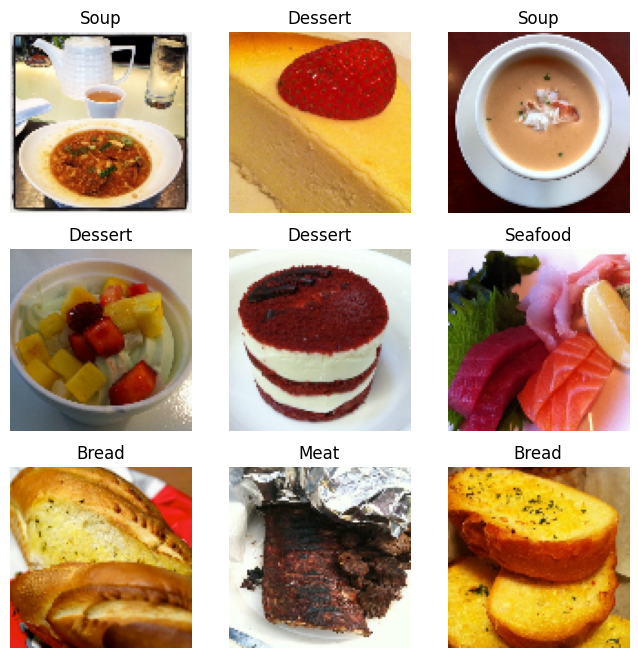

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
test_dataset = image_dataset_from_directory('food11/training',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 9866 files belonging to 11 classes.


In [10]:
test_dataset.class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

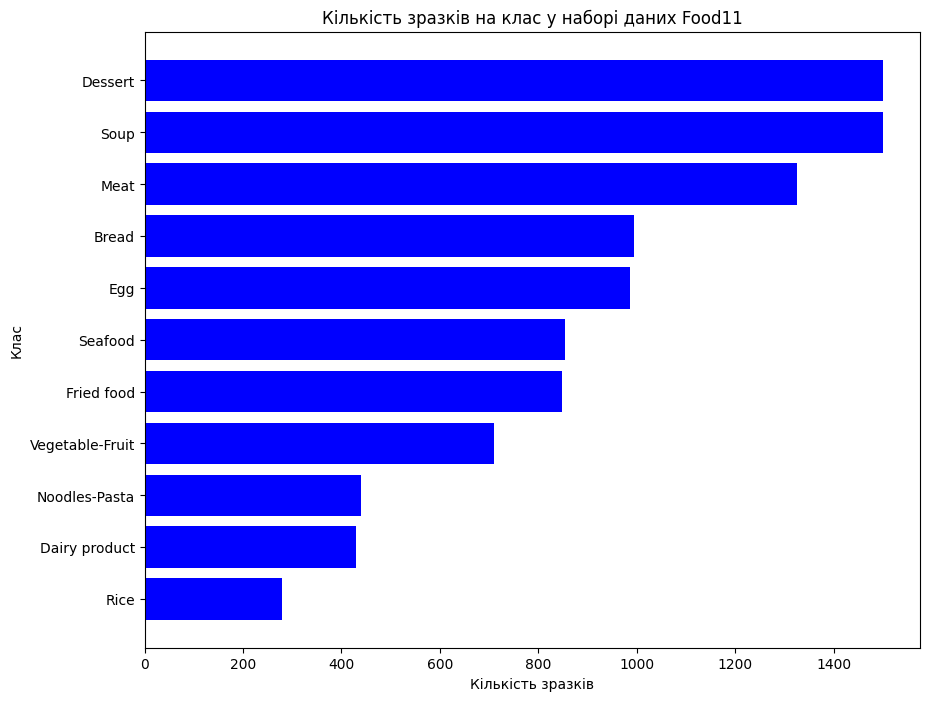

In [ ]:
dataset_path = 'food11/training'
class_counts = {}
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if file.endswith(('jpg', 'png', 'jpeg'))])
        class_counts[class_folder] = num_images

sorted_classes = sorted(class_counts.items(), key=lambda x: x[1])

classes = [item[0] for item in sorted_classes]
counts = [item[1] for item in sorted_classes]

plt.figure(figsize=(10, 8))
plt.barh(classes, counts, color='blue')
plt.xlabel('Кількість зразків')
plt.ylabel('Клас')
plt.title('Кількість зразків на клас у наборі даних Food11')
plt.show()

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [26]:
# Створюємо послідовну модель
model = Sequential()
# Згортковий шар
model.add(Conv2D(16, (5, 5), padding='same',
 input_shape=(100, 100, 3), activation='relu'))
# Шар підвиборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Згортковий шар
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# Шар підвиборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Згортковий шар
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Шар підвиборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Згортковий шар
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
# Шар підвиборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Повнозв'язкова частина нейронної мережі для класифікації
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(131, activation='softmax'))

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [14]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=15,
                    verbose=2)

Epoch 1/15
35/35 - 244s - 7s/step - accuracy: 0.1435 - loss: 4.8732 - val_accuracy: 0.3061 - val_loss: 2.1674
Epoch 2/15
35/35 - 267s - 8s/step - accuracy: 0.2270 - loss: 2.2296 - val_accuracy: 0.3090 - val_loss: 1.9918
Epoch 3/15
35/35 - 241s - 7s/step - accuracy: 0.2891 - loss: 2.0375 - val_accuracy: 0.3732 - val_loss: 1.9154
Epoch 4/15
35/35 - 264s - 8s/step - accuracy: 0.3386 - loss: 1.9175 - val_accuracy: 0.3673 - val_loss: 1.8682
Epoch 5/15
35/35 - 265s - 8s/step - accuracy: 0.3792 - loss: 1.7895 - val_accuracy: 0.3994 - val_loss: 1.8295
Epoch 6/15
35/35 - 258s - 7s/step - accuracy: 0.4184 - loss: 1.6838 - val_accuracy: 0.3994 - val_loss: 1.8545
Epoch 7/15
35/35 - 247s - 7s/step - accuracy: 0.4630 - loss: 1.5503 - val_accuracy: 0.4082 - val_loss: 1.7823
Epoch 8/15
35/35 - 256s - 7s/step - accuracy: 0.5214 - loss: 1.3867 - val_accuracy: 0.3936 - val_loss: 1.8181
Epoch 9/15
35/35 - 243s - 7s/step - accuracy: 0.5764 - loss: 1.2248 - val_accuracy: 0.3907 - val_loss: 1.9206
Epoch 10/1

In [15]:
scores = model.evaluate(test_dataset, verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9235 - loss: 0.3585


In [16]:
print("Частка вірних відповідей на тестових даних, у відсотках:", round(scores[1] * 100, 4))

Частка вірних відповідей на тестових даних, у відсотках: 92.0535


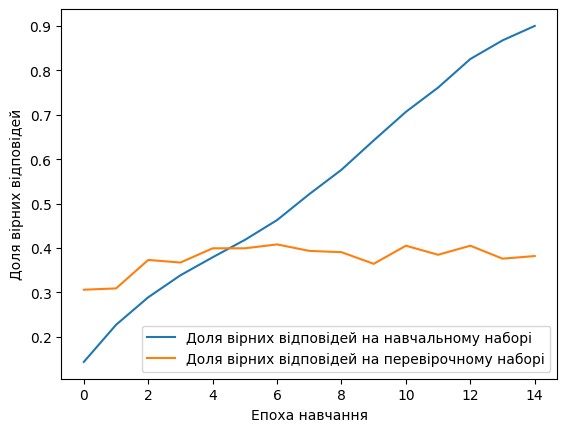

In [17]:
plt.plot(history.history['accuracy'],
 label='Доля вірних відповідей на навчальному наборі')
plt.plot(history.history['val_accuracy'],
 label='Доля вірних відповідей на перевірочному наборі')
plt.xlabel('Епоха навчання')
plt.ylabel('Доля вірних відповідей')
plt.legend()
plt.show()

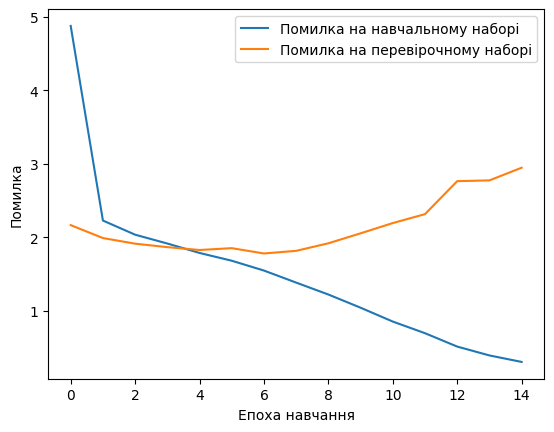

In [18]:
plt.plot(history.history['loss'],
 label='Помилка на навчальному наборі')
plt.plot(history.history['val_loss'],
 label='Помилка на перевірочному наборі')
plt.xlabel('Епоха навчання')
plt.ylabel('Помилка')
plt.legend()
plt.show()

In [19]:
model.save("model_food.h5")

In [ ]:
files.download("food11_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>